This notebook is based entirely on the knowledge which I gained from doing the Machine Learning courses on Kaggle and reading sklearn/pandas documentation.  

I tried here to create an automated pipeline for feature preparation, which does:
- remove numerical columns with a large amount of missing data,
- impute missing data in categorical columns and in the numerical columns which have most entries and a small part of missing data,
- removes features have small mutual information with the target,
- creates new features by applying PCA to numerical features,
- performs One Hot Encoding on the categorical data.

Next, the preprocessed data is fed into a simple XGBRegressor model, which can be run with early stopping rounds, when performed on the train/validations sets.



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

X = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col='Id') 
X_test = pd.read_csv('../input/home-data-for-ml-course/test.csv', index_col='Id')

X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=0)

First, analyze general facts about the data (if there are missing values and what types of data occur).

In [2]:
print(f'There is a total of {len(X.columns)} features.')

cols_with_missing = set([col for col in X.columns if X[col].isnull().any()])
cols_with_missing.update([col for col in X_test.columns if X_test[col].isnull().any()])
print(f'There are {len(cols_with_missing)} features with missing entries.')

cat = (X.dtypes == 'object')
categorical_cols = list(cat[cat].index)
print(f'There are {len(categorical_cols)} categorical features.')

num = (X.dtypes != 'object')
num_cols = list(num[num].index)
print(f'There are {len(num_cols)} numerical features.')

There is a total of 79 features.
There are 34 features with missing entries.
There are 43 categorical features.
There are 36 numerical features.


Check for outliers by using PCA and visualising the first 10 components, which explain the most variance.

The first 10 PCA components explain these amounts of variance:
[0.19386639 0.09564245 0.06510423 0.05987158 0.04440183 0.03584957
 0.03483578 0.03356583 0.03259043 0.03155213]


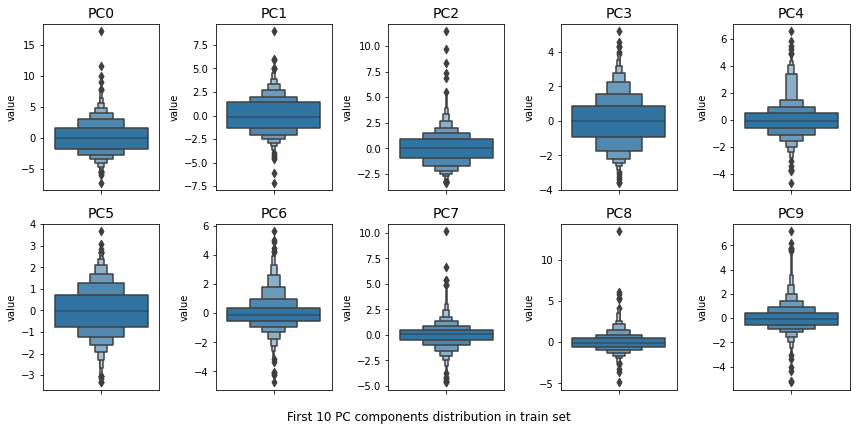

In [3]:
def apply_pca(X, standardize=True):
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    pca = PCA()
    X_pca = pca.fit_transform(X)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

pca_features = [col for col in num_cols if not X[col].isnull().any()]
pca, X_pca, loadings = apply_pca(X[pca_features])

print('The first 10 PCA components explain these amounts of variance:')
print(pca.explained_variance_ratio_[:10])

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for idx, ax in enumerate(axes.flat):
    
    component_to_see = f'PC{idx+1}'
    distribution = X_pca.melt()
    distribution = distribution.loc[distribution['variable'] == component_to_see]
    
    sns.boxenplot(data=distribution, y="value", ax=ax)
    ax.set_title(f'PC{idx}', fontsize=14)

fig.supxlabel('First 10 PC components distribution in train set', ha='center')
fig.tight_layout()
plt.show()

Below, I define the function which will preprocess data. It takes as arguments: 
- a train set `X` 
- a test/validation set `X_test` 
- the target output as `y`.  

It works on copies of the `X` and `X_test` data, and returns these two datasets after completing all preprocessing steps, which include:
- removing columns which have more than `missing_threshold` missing entries,
- imputing missing data in the rest of the numerical columns with missing data using the median value or 0,
- imputing missing data in categorical columns with a new value (often the NaN in categorical data has the meaning of a new category, e.g. "the absence of a garage") 
- removing features have mutual information with the target smaller than `mutual_inf_threshold`,
- creates new features by applying PCA to existing numerical features and then adding as new features the first `pca_components_to_include` components
- dropping categorical data that have cardinality larger than `low_cardinality_threshold`,
- performing One Hot Encoding on the low-cardinality categorical data.


In [4]:
def drop_missing_values(data, data_test, cols_with_missing, verbose=False):
    cols_to_drop = [col for col in cols_with_missing if data[col].isnull().sum() > missing_threshold]

    if verbose:
        print('Columns with missing values: ')
        print(cols_with_missing)
        print('\n Columns which will be dropped due to a lot of missing values: ')
        print(cols_to_drop)

    data = data.drop(cols_to_drop, axis=1)
    data_test = data_test.drop(cols_to_drop, axis=1)

    return data, data_test, cols_to_drop


def impute_missing_values(X, X_test, cols_with_missing, fill_with_median):

    data = X.copy()
    data_test = X_test.copy()

    cols_with_missing_num = [col for col in cols_with_missing if data[col].dtype != "object"]
    cols_with_missing_cat = [col for col in cols_with_missing if data[col].dtype == "object"]

    for column in cols_with_missing_num:
        if column in fill_with_median:
            data[column] = data[column].fillna(data[column].median())
            data_test[column] = data_test[column].fillna(data_test[column].median())
        else:
            data[column] = data[column].fillna(0)
            data_test[column] = data_test[column].fillna(0)

    for column in cols_with_missing_cat:
        data[column] = data[column].fillna('N')
        data_test[column] = data_test[column].fillna('N')

    data.columns = X.columns
    data_test.columns = X_test.columns

    return data, data_test


def remove_low_mi(X, y, X_test, mutual_inf_threshold, verbose=False):

    data = X.copy()
    data_test = X_test.copy()

    num = (data.dtypes != 'object')
    num_cols = list(num[num].index)

    mi_scores = make_mi_scores(data[num_cols], y, 'auto')
    unimportant_columns = [index for index, score in mi_scores.iteritems()
                           if score < mutual_inf_threshold]
    if verbose:
        print('\nColumns which will be dropped: ')
        print(unimportant_columns)

    high_mi_columns = list(set(num_cols) - set(unimportant_columns))
    high_mi = data.drop(unimportant_columns, axis=1)
    high_mi_test = data_test.drop(unimportant_columns, axis=1)

    return high_mi, high_mi_test, high_mi_columns


def make_mi_scores(X, y, discrete_features):

    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def create_pca_features(X, X_test, columns, pca_components_to_include):

    data = X.copy()
    data_test = X_test.copy()

    pca, X_pca, loadings = apply_pca(data[columns], standardize=False)
    pca_test, X_pca_test, loadings_test = apply_pca(data_test[columns], standardize=False)

    first_n_components = [f"PC{i+1}" for i in range(pca_components_to_include)]
    data_after_pca = data.join(X_pca[first_n_components])
    data_after_pca_test = data_test.join(X_pca_test[first_n_components])

    return data_after_pca, data_after_pca_test


def one_hot_encoding(X, X_test, categorical_cols, low_cardinality_threshold):

    data = X.copy()
    data_test = X_test.copy()

    low_cardinality_cols = [col for col in categorical_cols
                            if data[col].nunique() < low_cardinality_threshold]
    high_cardinality_cols = list(set(categorical_cols)-set(low_cardinality_cols))

    lc_X = data.drop(high_cardinality_cols, axis=1)
    lc_X_test = data_test.drop(high_cardinality_cols, axis=1)

    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    oh_cols = pd.DataFrame(OH_encoder.fit_transform(lc_X[low_cardinality_cols]))
    oh_cols_test = pd.DataFrame(OH_encoder.transform(lc_X_test[low_cardinality_cols]))

    oh_cols.index = X.index
    oh_cols_test.index = X_test.index
    num_X = data.drop(categorical_cols, axis=1)
    num_X_test = data_test.drop(categorical_cols, axis=1)
    oh_X = pd.concat([num_X, oh_cols], axis=1)
    oh_X_test = pd.concat([num_X_test, oh_cols_test], axis=1)

    return oh_X, oh_X_test


def preprocessing_pipeline(X, y, X_test,
                           missing_threshold=100,
                           mutual_inf_threshold=0.05,
                           low_cardinality_threshold=15,
                           pca_components_to_include=10,
                           verbose=False):

    data = X.copy()
    data_test = X_test.copy()
    if verbose:
        print('\nNumber of features at the beginning:')
        print(len(data.columns), len(data_test.columns))

    cols_with_missing = set([col for col in data.columns if data[col].isnull().any()])
    cols_with_missing.update([col for col in data_test.columns if data_test[col].isnull().any()])
    data, data_test, dropped_columns = drop_missing_values(data, data_test, cols_with_missing, verbose)
    if verbose:
        print('\nNumber of features after dropping missing values:')
        print(len(data.columns), len(data_test.columns))

    cols_with_few_missing = list(set(cols_with_missing) - set(dropped_columns))
    fill_with_median = ['LotFrontage']
    imputed, imputed_test = impute_missing_values(data, data_test,
                                                  cols_with_few_missing,
                                                  fill_with_median)
    msg = "There are still NaN values in the data after imputation!"
    assert not [col for col in imputed.columns if imputed[col].isnull().any()], msg
    assert not [col for col in imputed_test.columns if imputed_test[col].isnull().any()], msg
    if verbose:
        print('\nNumber of features after imputation:')
        print(len(imputed.columns))
        print(len(imputed_test.columns))

    high_mi, high_mi_test, high_mi_columns = remove_low_mi(imputed, y, imputed_test,
                                                           mutual_inf_threshold, verbose)
    if verbose:
        print('\nNumber of features after dropping low MI features:')
        print(len(high_mi.columns))
        print(len(high_mi_test.columns))

    data_after_pca, data_after_pca_test = create_pca_features(high_mi, high_mi_test,
                                                              high_mi_columns,
                                                              pca_components_to_include)

    if verbose:
        print('\nNumber of features after adding PCA components:')
        print(len(data_after_pca.columns))
        print(len(data_after_pca_test.columns))

    cat = (data_after_pca.dtypes == 'object')
    categorical_cols = list(cat[cat].index)

    OH_X, OH_X_test = one_hot_encoding(data_after_pca, data_after_pca_test,
                                       categorical_cols,
                                       low_cardinality_threshold)

    if verbose:
        print('\nNumber of features after OHE:')
        print(len(OH_X.columns))
        print(len(OH_X_test.columns))

    return OH_X, OH_X_test

Next, four loops are run to find the optimal values of the hyperparameters of the preprocessing pipeline. 
Note that XGBRegressor is run with early stopping rounds to speed up the evaluation.

In [5]:
smallest_mae = 30_000

for missing_threshold in [100, 500, 1000]:
    for mutual_inf_threshold in [0, 0.02, 0.05, 0.1, 0.15]:
        for low_cardinality_threshold in [10, 20, 30]:
            for pca_components_to_include in [0, 5, 10]:
                print(
                    f'running: missing_threshold = {missing_threshold}, '
                    f' mutual_inf_threshold = {mutual_inf_threshold}, '
                    f'low_cardinality_threshold = {low_cardinality_threshold}, '
                    f'pca_components_to_include = {pca_components_to_include}'
                )

                processed_X_train, processed_X_valid = preprocessing_pipeline(X_train, y_train, X_valid,
                                                                              missing_threshold=missing_threshold,   
                                                                              mutual_inf_threshold=mutual_inf_threshold,
                                                                              low_cardinality_threshold=low_cardinality_threshold,
                                                                              pca_components_to_include=pca_components_to_include)
                
                model = XGBRegressor(n_estimators=5_000, learning_rate = 0.02)
                model.fit(processed_X_train, y_train, early_stopping_rounds=10,
                          eval_set=[(processed_X_valid, y_valid)],verbose=False)
                preds_test = model.predict(processed_X_valid)

                mae = mean_absolute_error(y_valid, preds_test)
                print(f'mae = {mae}')
                print('-----------------')
                if mae < smallest_mae:
                    smallest_mae = mae
                    best_params = missing_threshold, mutual_inf_threshold, low_cardinality_threshold, pca_components_to_include

print(f'smallest MAE: {smallest_mae}')
print(f'best parameters: {best_params}')

running: missing_threshold = 100,  mutual_inf_threshold = 0, low_cardinality_threshold = 10, pca_components_to_include = 0
mae = 16601.47709760274
-----------------
running: missing_threshold = 100,  mutual_inf_threshold = 0, low_cardinality_threshold = 10, pca_components_to_include = 5
mae = 17307.93172089041
-----------------
running: missing_threshold = 100,  mutual_inf_threshold = 0, low_cardinality_threshold = 10, pca_components_to_include = 10
mae = 17022.426102311645
-----------------
running: missing_threshold = 100,  mutual_inf_threshold = 0, low_cardinality_threshold = 20, pca_components_to_include = 0
mae = 16612.274748501713
-----------------
running: missing_threshold = 100,  mutual_inf_threshold = 0, low_cardinality_threshold = 20, pca_components_to_include = 5
mae = 17178.642069777397
-----------------
running: missing_threshold = 100,  mutual_inf_threshold = 0, low_cardinality_threshold = 20, pca_components_to_include = 10
mae = 16743.123983304795
-----------------
runn

Finally, the best parameters will be used to the generate predictions on the entire training set.

In [7]:
processed_X, processed_X_test = preprocessing_pipeline(X, y, X_test, 
                                                       missing_threshold=best_params[0],      
                                                       mutual_inf_threshold=best_params[1],
                                                       low_cardinality_threshold=best_params[2])
print(len(processed_X.columns), len(processed_X_test.columns))

model = XGBRegressor(n_estimators = 5_000, learning_rate = 0.01)
model.fit(processed_X, y)
preds_test = model.predict(processed_X_test)

output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)
print('output saved')

287 287
output saved


The last thing which remains would be optimize the XGBRegressor parameters, e.g. using GridSearchCV.